Lo scopo di questo notebook è analizzare i consumi degli edifici U1 e U6 di bicocca sfruttando i dati del triennio 2018-2020.

## Import

In [ ]:
#!pip install pmdarima

In [ ]:
# scelgo di non visualizzare i warnings per futuri agg. delle librerie ARIMA
import warnings
warnings.filterwarnings('ignore')

# import per lettura del file
import pandas as pd
import glob
import os

# import per visualizzazione grafici + setting dimensione e stile
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (17,10)

# import per serie storica
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import pmdarima as pmd

# per score fitting
from sklearn.metrics import r2_score

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# function for converting hour

"""
  correggo la data inserendo un orario valido. 
    - Se è mezzanotte metto 00:00
    - Se sono negli orari di mezzanotte metto davanti 00:
    - Se sono tra l'1 e le 9 metto : dopo il primo numero
    - Se sono tra le 10 e le 23 metto : dopo i primi due numeri
""" 

def correct_hour(hour):
  if hour == "0":
    hour = "00:00"
  elif (len(hour) < 5):
    hour = "00:" + hour[:2]
  elif (len(hour) >= 5 and len(hour) < 6):
    hour = hour[:1] + ":" + hour[1:3]
  else:
    hour = hour[:2] + ":" + hour[2:4]

  return hour

## U1
Effettuo la lettura dei dati dell'edificio U1 ed inizio ad ispezionarli tramite una serie di grafici preliminari.

In [ ]:
# Leggo i file dei 3 anni da drive e li carico in un dataframe pandas
path = '/content/drive/My Drive/DsLab/U1/2018'
filepaths = [file for file in glob.iglob(os.path.join(path, "*.xlsx"))]
path = '/content/drive/My Drive/DsLab/U1/2019'
filepaths += [file for file in glob.iglob(os.path.join(path, "*.xlsx"))]
path = '/content/drive/My Drive/DsLab/U1/2020'
filepaths += [file for file in glob.iglob(os.path.join(path, "*.xlsx"))]


df_U1_hour = pd.concat([pd.read_excel(f,
                                usecols=['POD', 'DATA', 
                                         'ORA','CONSUMO_ATTIVA_PRELEVATA'],
                                dtype={'ORA':'string'}) for f in  filepaths])

In [ ]:
# controllo se esistono righe duplicate, nel caso le elimino
if df_U1_hour.duplicated(['DATA', 'ORA']).any():
  print("Eliminazione righe duplicate...")
  df_U1_hour = df_U1_hour.drop_duplicates(subset = ['DATA', 'ORA'], keep='last')

# Stampo il numero di righe con valori nulli
print("Righe con valori nulli: " + str(df_U1_hour.isnull().any(axis = 1).sum()))

Eliminazione righe duplicate...
Righe con valori nulli: 0


In [ ]:
# Converto la colonna ORA in formato datetime applicando la funzione di 
# conversione implementata precedentemente
df_U1_hour['Time'] = pd.to_datetime(df_U1_hour.pop('ORA').
                               map(lambda a: correct_hour(a))).dt.time

# Creo una nuova colonna in cui mantengo solo il riferimento orario e non i minuti
df_U1_hour['Hour'] = df_U1_hour['Time'].apply(lambda x: x.hour)

# Modifica il formato della colonna Data 
df_U1_hour['Date'] = pd.to_datetime(df_U1_hour.pop('DATA').astype(str), 
                            format='%Y%m%d')

# rinomino la colonna del consumo
df_U1_hour.rename(columns = {'CONSUMO_ATTIVA_PRELEVATA': 'kWh'}, 
                            inplace = True)

In [ ]:
# Raggruppo le righe per data e ora calcolando la media dei valori
# in questo modo ottengo il consumo orario 
# (suppongo che l'energia utilizzata nei 15 min sia costante)
df_U1_hour = df_U1_hour.groupby(['Date', 'Hour'], as_index=False).mean()

In [ ]:
# Raggruppo le righe per data e sommo i valori per ottenere il totale dell'energia
# consumata per ogni giorno 
df_U1 = df_U1_hour.groupby(['Date'], as_index=False).sum()

# Aggiungo il riferimento al numero di giorno della settimana
df_U1['Weekday'] = df_U1.apply(lambda row: row['Date'].weekday(), axis = 1)
# Aggiungo un riferimento per sapere se il giorno è lavorativo (lunedi-venerdi)
df_U1['Workday'] = df_U1.apply(lambda row: row['Weekday'] < 5, axis = 1)


# elimino la colonna con l'ora in quando non mi serve più
df_U1.pop('Hour');

# setto la colonna Date come indice
# df_U1.set_index('Date', inplace=True)

In [ ]:
# visualizzo le prime 5 righe del dataset ripulito
df_U1.head()

,Date,kWh,Weekday,Workday
0,2018-01-01,1543.20,0,True
1,2018-01-02,1681.95,1,True
2,2018-01-03,1809.30,2,True
3,2018-01-04,1787.10,3,True
4,2018-01-05,1820.70,4,True


### Panoramica dei dati
Visualizzo alcuni grafici per cercare di capire come evolve l'andamento dei consumi durante i giorni della settimana, i mesi e gli anni a disposizione.

#### Analisi del consumo medio per giorno della settimana
Il primo grafico di analisi permette di analizzare la variazione dei consumi tra i diversi giorni della settimana.

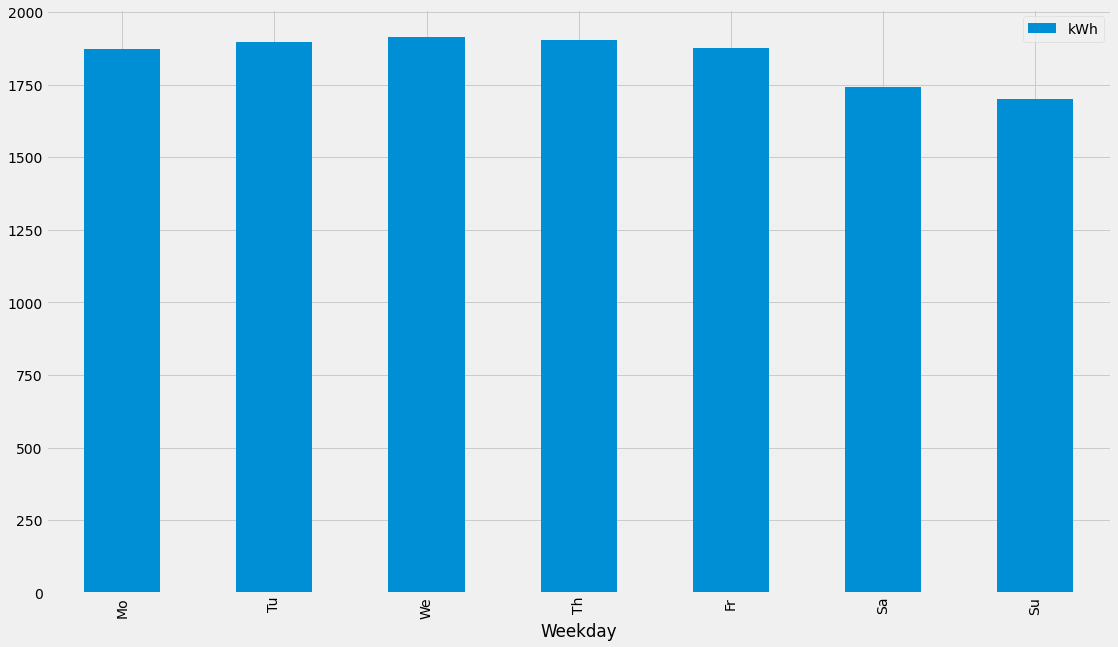

In [ ]:
# etichetta per visualizzazione negli assi
weekday_labels = ['Mo','Tu','We','Th','Fr','Sa','Su']

# raggruppo i dati per giorno della settimana e ne calcolo la media del consumo
ax = df_U1[['Weekday', 'kWh']].groupby(['Weekday']).mean().plot(kind = 'bar')

# Visualizzo il nome dei giorni sull'etichetta
# (semicolon finale per prevenire il printing della lista)
ax.set_xticklabels(weekday_labels);

#### Analisi del consumo medio per mese
Questo grafico permette di analizzare come varia il consumo di energia elettrica nei diversi mesi dell'anno.

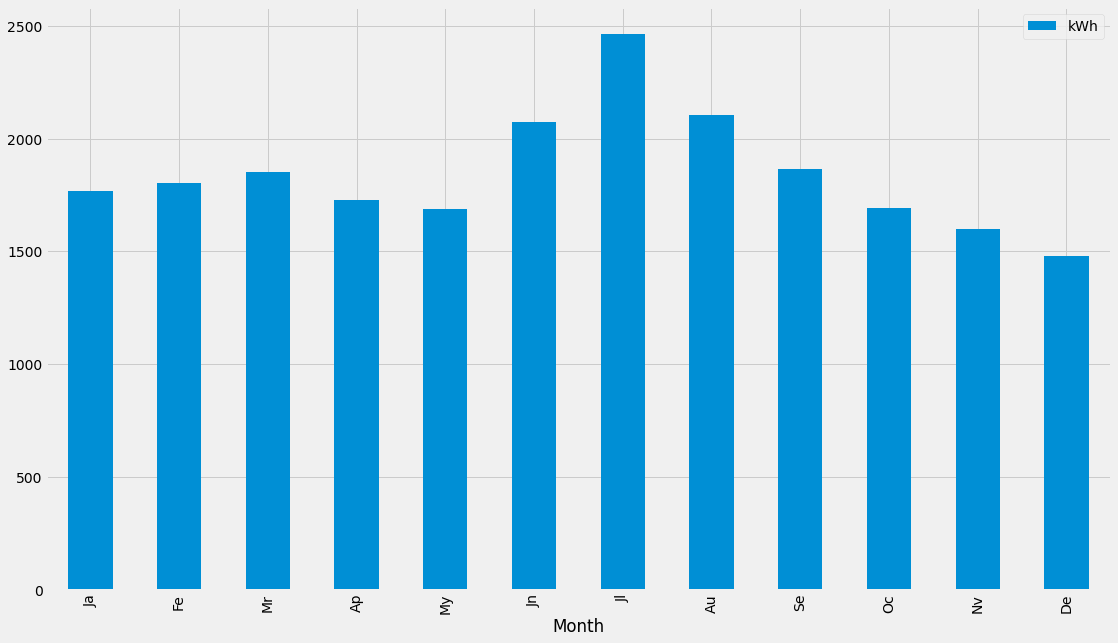

In [ ]:
# etichetta per visualizzazione negli assi
month_labels = ['Ja','Fe','Mr','Ap','My','Jn','Jl','Au','Se','Oc','Nv','De']

# aggiungo la nuova colonna month estraendola dalla data
df_U1['Month'] = df_U1.apply(lambda row: row['Date'].month, axis=1)

# raggruppo i dati per mese e calcolo la media del consumo
ax = df_U1[['Month', 'kWh']].groupby(['Month']).mean().plot(kind = 'bar')

# Visualizzo il nome dei giorni sull'etichetta
# (semicolon finale per prevenire il printing della lista)
ax.set_xticklabels(month_labels);

#### Analisi del consumo medio per anno
Questo grafico permette di analizzare come varia il consumo di energia elettrica nei diversi anni.

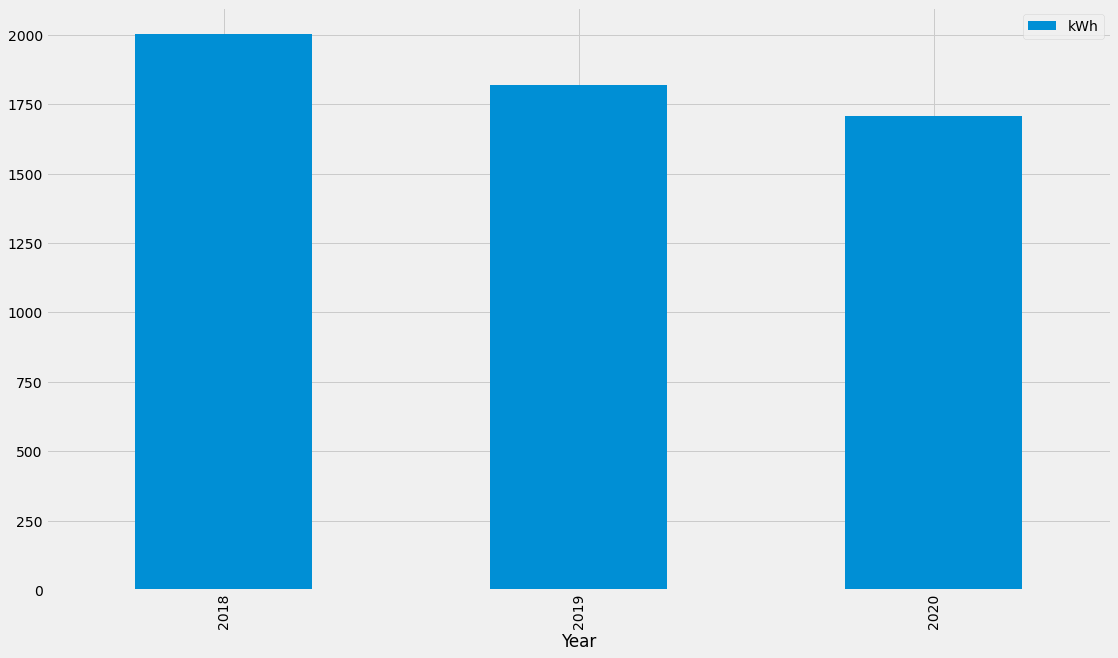

In [ ]:
# aggiungo la nuova colonna Year estraendola dalla data
df_U1['Year'] = df_U1.apply(lambda row: row['Date'].year, axis=1)

# raggruppo i dati per anno e calcolo la media del consumo
df_difference_temp = df_U1[['Year', 'kWh']].groupby(['Year']).mean()

# Visualizzo il grafico
df_difference_temp.plot(kind = 'bar');

La variazione sembra minima, sembra infatti che negli anni ci sia stato un decremento costante, quindi la differenza tra i diversi anni come valore numerico.

In [ ]:
# calcolo la variazione tra 18-19
difference1819 = (df_difference_temp.iloc[0]['kWh'] - 
                  df_difference_temp.iloc[1]['kWh'])
print("Variazione puntuale 2018-2019:", round(difference1819,2))

# calcolo la variazione tra 19-20
difference1920 = (df_difference_temp.iloc[1]['kWh'] - 
                df_difference_temp.iloc[2]['kWh'])
print("Variazione puntuale 2019-2020:", round(difference1920,2))

# calcolo le variazioni percentuali
percent_difference1819 = (difference1819/df_difference_temp.iloc[0]['kWh'])*100
print("\n\nVariazione percentuale 2018-2019: {}%".format(round(percent_difference1819, 2)))

percent_difference1920 = (difference1920/df_difference_temp.iloc[1]['kWh'])*100
print("Variazione percentuale 2019-2020: {}%".format(round(percent_difference1920, 2)))

Variazione puntuale 2018-2019: 181.52
Variazione puntuale 2019-2020: 113.14


Variazione percentuale 2018-2019: 9.07%
Variazione percentuale 2019-2020: 6.22%


#### Analisi del consumo medio per fasce orarie
Analizzo il consumo medio dell'edificio U1 nelle diverse ore della giornata.

In [ ]:
# utilizzo il dataset temporaneo con il riferimento delle ore per i prossimi grafici

# Aggiungo il riferimento al numero di giorno della settimana al dataset temporaneo
df_U1_hour['Weekday'] = df_U1_hour.apply(lambda row: row['Date'].weekday(), axis = 1)

# raggruppo i dati per giorno della settimana ed ora
df_U1_day_hour = df_U1_hour[['Weekday','Hour', 'kWh']].groupby(['Weekday','Hour']).mean()
df_U1_day_hour.reset_index(inplace = True)

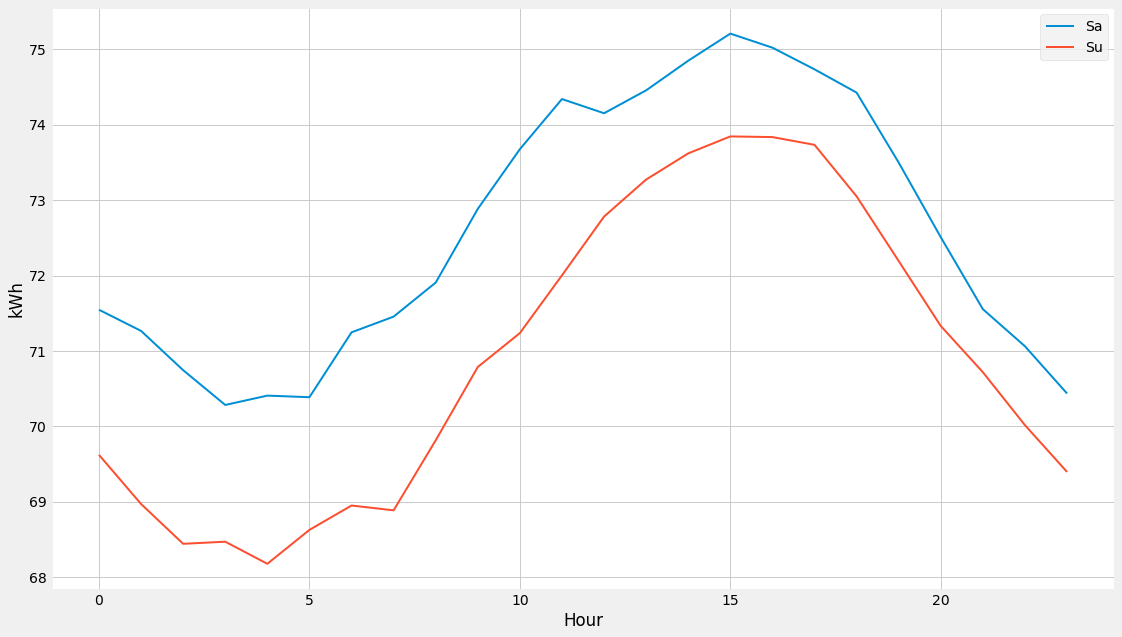

In [ ]:
# visualizzo il grafico per il confronto sabato-domenica
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('Hour')
ax.set_ylabel('kWh')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
for idx in range(5,7):
    plt.plot(df_U1_day_hour[df_U1_day_hour['Weekday'] == idx]['Hour'],
             df_U1_day_hour[df_U1_day_hour['Weekday'] == idx]['kWh'], 
             linewidth=2, label = weekday_labels[idx])
plt.legend()
fig.show()

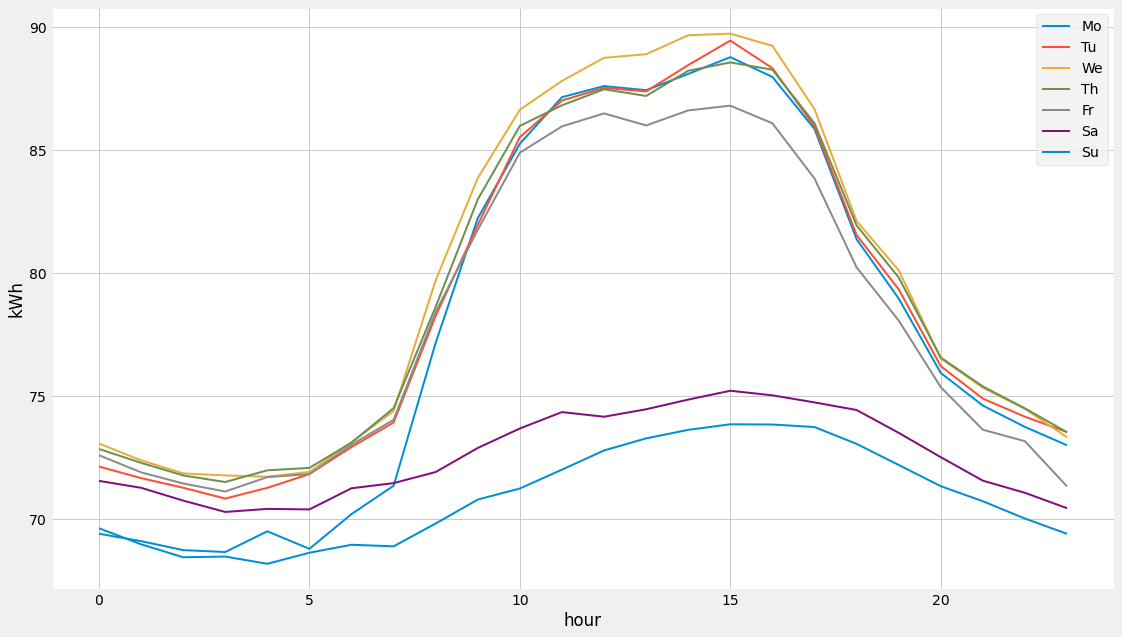

In [ ]:
# visualizzo il grafico con tutti i giorni della settimana
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('hour')
ax.set_ylabel('kWh')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
for idx in range(7):
    plt.plot(df_U1_day_hour[df_U1_day_hour['Weekday'] == idx]['Hour'],
             df_U1_day_hour[df_U1_day_hour['Weekday'] == idx]['kWh'], 
             linewidth=2, label = weekday_labels[idx])
plt.legend()
fig.show()

### Studio dei valori anomali
Verifico se ci sono stati dei giorni che hanno fatto registrare dei valori anomali sia in positivo che in negativo. Per avere un'idea di partenza inizio visualizzando la frequenza dei kWh utilizzati in modo da capire quali valori ricorrono più spesso nelle rilevazioni.
<br><br>

*Nota: per queste analisi utilizzo il dataset con i riferimenti degli orari e non quello aggregato*

In [ ]:
# calcolo media e dev. standard dei kWh
std_U1 = df_U1_hour['kWh'].std()
mean_U1 = df_U1_hour['kWh'].mean()
lower_bound_U1 = mean_U1 - 2 * std_U1
upper_bound_U1 = mean_U1 + 2 * std_U1

Come si può notare dal grafico mediamente si utilizzano circa 79 kWh, ci sono dei picchi riportati nella coda di dx abbastanza lunga, dovuti probabilmente ai mesi estivi/convegni/eventi che richiedono un maggior utilizzo di corrente. <br>

Analizzo valori particolarmente bassi o alti, considero come tali i valori fuori dal range [μ - 2σ, μ + 2σ]. Questi valori si trovano al di fuori delle linee gialle tratteggiate nel grafo.

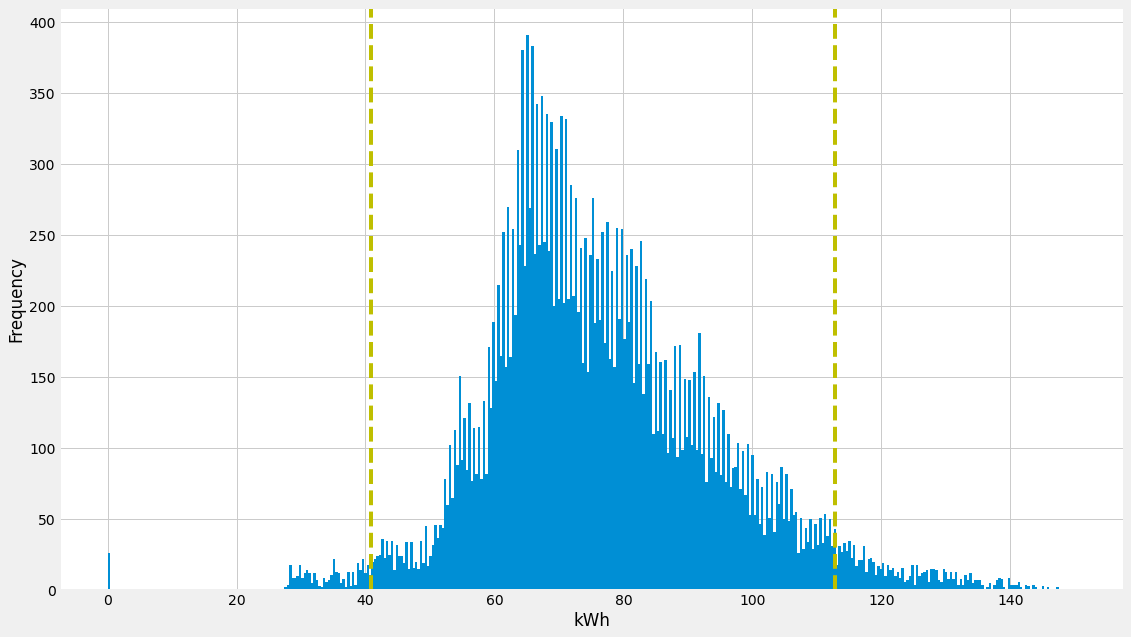

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('#FFFFFF')
ax.set_xlabel('kWh')
ax.set_ylabel('Count')
ax.tick_params(colors='k')
ax.yaxis.label.set_color('k')
ax.xaxis.label.set_color('k')
df_U1_hour['kWh'].plot(kind = 'hist', bins = 400)
plt.axvline(x=lower_bound_U1, color='y', linestyle='--')
plt.axvline(x=upper_bound_U1, color='y', linestyle='--')
fig.show()

#### Valori particolarmente bassi

Inizio studiando i valori particolarmente bassi, noto subito che nel grafico è presente anche una barra abbastanza alta sullo 0 che attenzionerò successivamente. Considero come valori bassi quelli al di sotto della soglia rappresentata dalla riga gialla.



In [ ]:
# estraggo tutti i valori particolarmente bassi
df_U1_lower = df_U1_hour.loc[(df_U1_hour['kWh'] < lower_bound_U1)]
df_U1_lower.head()

,Date,Hour,kWh,Weekday
5619,2018-08-23,4,40.35,3
7245,2018-10-29,22,39.60,0
7246,2018-10-29,23,39.30,0
7248,2018-10-30,1,38.85,1
7249,2018-10-30,2,38.85,1


Noto che ci sono dei valori registrati in orari notturni e nei weekend, escludo quindi questi valori perchè non ritengo che siano anomali in quanto in quelle fasce di orari è normale che il consumo elettrico sia notevolmente minore. <br>

Dopo l'esclusione, come si nota dall'elenco dei giorni visualizzato sotto, si capisce subito che i valori particolarmente bassi si sono registrati in periodi di vacanza o nei giorni immediatamente prima/dopo le vacanze. Come ad esempio il 29/05/2020 che era un venerdì e lunedi 1/06/2020 era festivo quindi è presumibile che in università ci fossero molte meno persone per via del "ponte".

In [ ]:
# estraggo i valori bassi che non si verificano nei weekend/di notte
df_U1_lower = df_U1_lower.loc[(df_U1_lower['kWh'] != 0) & 
                              (df_U1_lower['Weekday'] < 5) & 
                              (df_U1_lower['Hour'] > 7) & 
                              (df_U1_lower['Hour'] < 20)]


print(df_U1_lower[['Date', 'Hour', 'kWh']].to_string())

            Date  Hour    kWh
8575  2018-12-24     8  33.90
8576  2018-12-24     9  35.70
8577  2018-12-24    10  36.60
8578  2018-12-24    11  31.80
8579  2018-12-24    12  35.85
8580  2018-12-24    13  30.00
8581  2018-12-24    14  32.25
8582  2018-12-24    15  29.85
8583  2018-12-24    16  30.90
8584  2018-12-24    17  29.25
8585  2018-12-24    18  31.80
8586  2018-12-24    19  28.80
8599  2018-12-25     8  31.20
8600  2018-12-25     9  29.25
8601  2018-12-25    10  30.75
8602  2018-12-25    11  28.35
8603  2018-12-25    12  27.75
8604  2018-12-25    13  31.35
8605  2018-12-25    14  28.80
8606  2018-12-25    15  32.10
8607  2018-12-25    16  28.20
8608  2018-12-25    17  30.90
8609  2018-12-25    18  29.55
8610  2018-12-25    19  28.05
8623  2018-12-26     8  28.50
8624  2018-12-26     9  31.95
8625  2018-12-26    10  28.50
8626  2018-12-26    11  30.30
8627  2018-12-26    12  30.15
8628  2018-12-26    13  28.65
8629  2018-12-26    14  29.55
8630  2018-12-26    15  30.90
8631  2018

#### Zeri
Dato che il grafico precedente ha evidenziato la presenza di alcuni zeri visualizzo in che giorni sono stati registrati per avere un quadro più completo.
Dall'analisi si evidenzia che sono soltanto 3 i giorni interessati dalla presenza di 0 come valore registrato, in due casi lo zero è stato registrato solo per un'ora e dunque è probabile che si sia trattato di un blackout, mentre il 31-07-2020 riporta 0 durante tutta la giornata e questo fa pensare a dei problemi nella rilevazione. <br>
Inoltre è importante segnalare che da bicocca non sono arrivate mail di interruzione dell'energia nei suddetti giorni, cercando alcuni riferimenti online risulta che:

- per il 29-06-2019 e 31-07-2020: diverse segnalazioni di **blackout**
- Mentre per il 12-08-2020 non si sono trovate segnalazioni, quindi la problematica riguarderebbe solo bicocca.

In [ ]:
df_U1_hour.loc[df_U1_hour['kWh'] == 0]

,Date,Hour,kWh,Weekday
13054,2019-06-29,0,0.0,5
14120,2019-08-12,10,0.0,0
22605,2020-07-31,0,0.0,4
22606,2020-07-31,1,0.0,4
22607,2020-07-31,2,0.0,4
22608,2020-07-31,3,0.0,4
22609,2020-07-31,4,0.0,4
22610,2020-07-31,5,0.0,4
22611,2020-07-31,6,0.0,4
22612,2020-07-31,7,0.0,4


#### Valori particolarmente alti

Posso presumere che i valori particolarmente alti si siano registrati nei periodi estivi, dunque di maggior caldo, quando ancora l'università non era chiusa (giugno, luglio, inizio e fine agosto). Come si può notare dalla successiva stampa quest'idea è confermata dai dati in quanto non sono presenti valori estremi al di fuori di questi periodi.

In [ ]:
df_U1_extreme = df_U1_hour.loc[(df_U1_hour['kWh'] > upper_bound_U1)]
print(df_U1_extreme['Date'].unique())

['2018-05-30T00:00:00.000000000' '2018-05-31T00:00:00.000000000'
 '2018-06-04T00:00:00.000000000' '2018-06-05T00:00:00.000000000'
 '2018-06-11T00:00:00.000000000' '2018-06-14T00:00:00.000000000'
 '2018-06-15T00:00:00.000000000' '2018-06-18T00:00:00.000000000'
 '2018-06-19T00:00:00.000000000' '2018-06-20T00:00:00.000000000'
 '2018-06-21T00:00:00.000000000' '2018-06-22T00:00:00.000000000'
 '2018-06-25T00:00:00.000000000' '2018-06-26T00:00:00.000000000'
 '2018-06-27T00:00:00.000000000' '2018-06-28T00:00:00.000000000'
 '2018-06-29T00:00:00.000000000' '2018-06-30T00:00:00.000000000'
 '2018-07-01T00:00:00.000000000' '2018-07-02T00:00:00.000000000'
 '2018-07-03T00:00:00.000000000' '2018-07-04T00:00:00.000000000'
 '2018-07-05T00:00:00.000000000' '2018-07-06T00:00:00.000000000'
 '2018-07-09T00:00:00.000000000' '2018-07-10T00:00:00.000000000'
 '2018-07-11T00:00:00.000000000' '2018-07-12T00:00:00.000000000'
 '2018-07-13T00:00:00.000000000' '2018-07-14T00:00:00.000000000'
 '2018-07-15T00:00:00.000

### Predizione consumi: Analisi iniziale della serie storica
Inizio a studiare la serie storica dei consumi attraverso alcuni grafici. Innanzitutto visualizzo la serie storica per avere un quadro generico.


In [ ]:
# setto la colonna date come index del dataset
df_U1.set_index('Date', inplace=True)

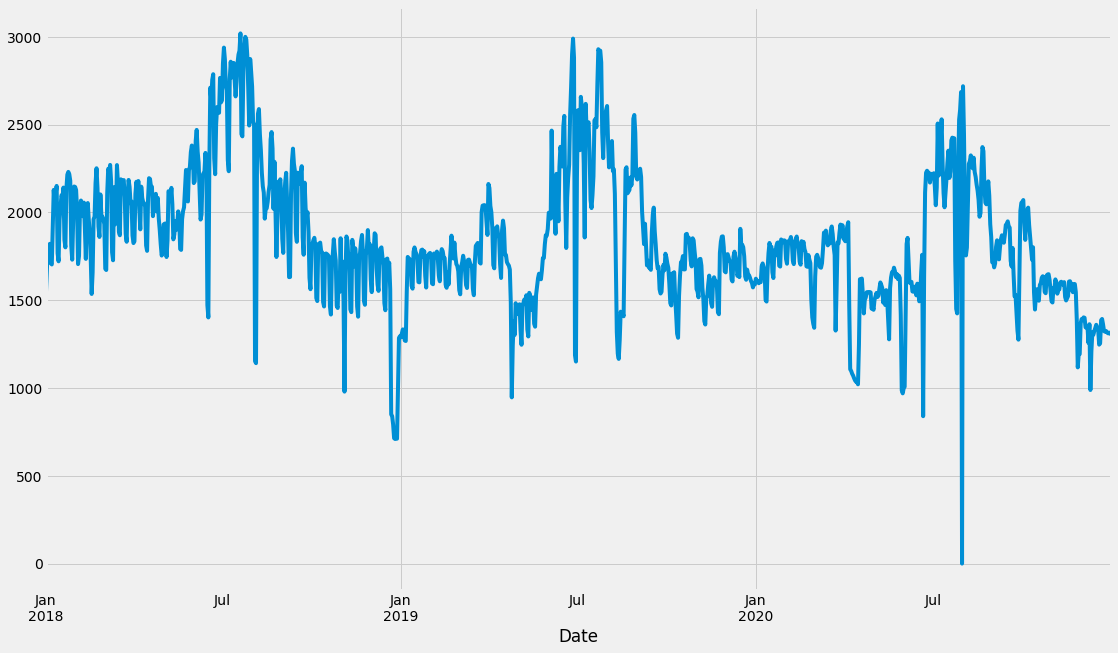

In [ ]:
# Visualizzo la serie storica
df_U1.kWh.plot()

Dalla visualizzazione dei consumi sembra che ci sia un certo pattern, ovvero nei mesi estivi il consumo aumenta, diminuisce in modo abbastanza drastico tra fine dicembre e inizio gennaio e rimae poi abbastanza stabile durante i restanti periodi. Separo quindi la serie storica in 4 componenti (valori osservati, trend, stagionalità, residui) per avere un quadro più completo.

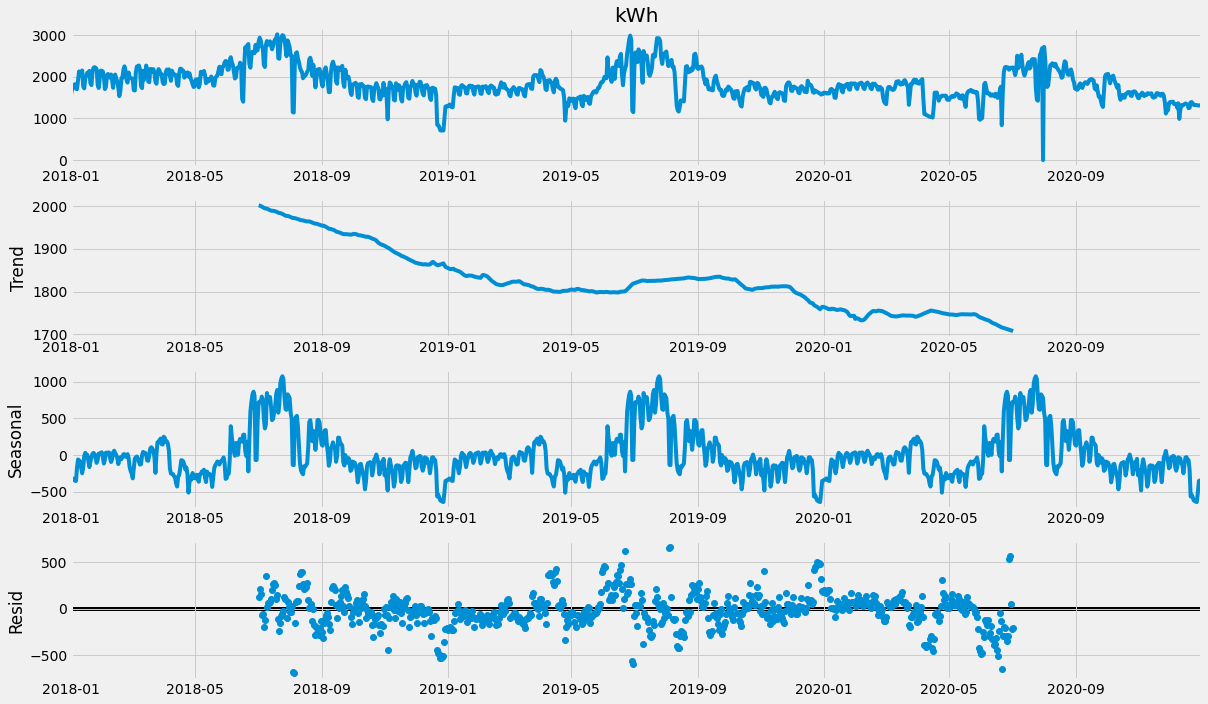

In [ ]:
# freq = 365 perchè i dati sono giornalieri
# utilizzo il modello 'additive' per via della presenza di 0 nella serie
sm.tsa.seasonal_decompose(df_U1.kWh, freq=365).plot();

Il trend conferma quanto già osservato nell'analisi del consumo medio per anno, ovvero che c'è un decremento abbastanza costante. Mentre anche il plot sulla stagionalità conferma le prime impressioni avute.

### Scelta del modello e dei parametri
Per scegliere il modello come prima cosa verifico se la serie storica è stazionaria attraverso il test di Dickey–Fuller.

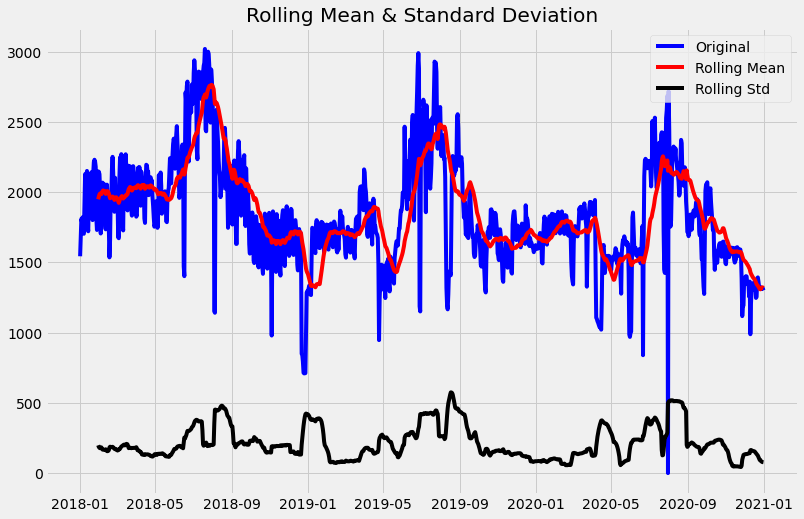

Results of Dickey-Fuller Test:
p-value = 0.0847. The series is likely non-stationary.
Test Statistic                   -2.641679
p-value                           0.084685
#Lags Used                       20.000000
Number of Observations Used    1075.000000
Critical Value (1%)              -3.436448
Critical Value (5%)              -2.864232
Critical Value (10%)             -2.568204
dtype: float64


In [ ]:
# determino se la serie è stazionaria o no
def test_stationarity(timeseries, window = 30, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
  

    print(dfoutput)
    
test_stationarity(df_U1.kWh)

Il p-value ottenuto dal test di Dickey sulla serie è 0.08, con un valore critico del 10% questa serie sarebbe stazionaria ma siccome vogliamo esserne assolutamente certi noi utilizziamo un valore critico pari all'1%.
Provo allora a differenziare i dati di un tempo (lag=1) e verificare se questo basta per rendere la serie stazionaria. <br>
Inoltre come si può notare il semplice modello a media mobile non risulta adatto a predire i valori della serie.

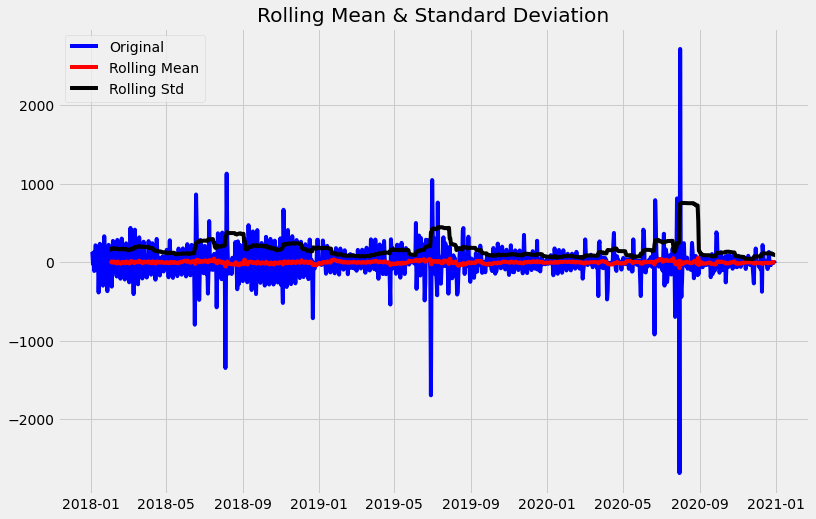

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -9.549304e+00
p-value                        2.597716e-16
#Lags Used                     2.000000e+01
Number of Observations Used    1.074000e+03
Critical Value (1%)           -3.436453e+00
Critical Value (5%)           -2.864235e+00
Critical Value (10%)          -2.568205e+00
dtype: float64


In [ ]:
df_U1_diff = df_U1 - df_U1.shift(1)
df_U1_diff.dropna(inplace=True)
test_stationarity(df_U1_diff.kWh)

Avendo differenziato la serie di 1 lag siamo riusciti a renderla stazionaria, infatti il valore del p-value in questo caso è estremamente piccolo. <br>
Dato questo risultato sappiamo che il parametro **d** per ARIMA sarà uguale ad 1, per avere un'idea degli altri parametri (p,q) utilizzo i grafici ACF e PACF sul modello differenziato.

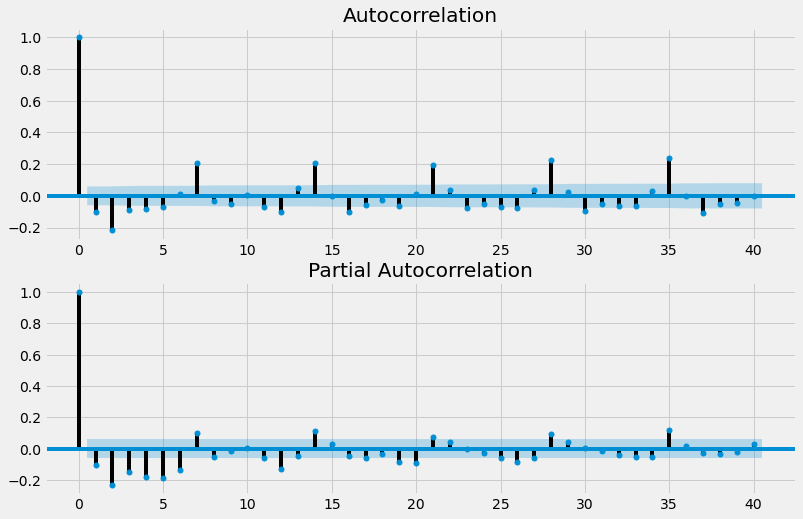

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_U1_diff.kWh, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_U1_diff.kWh, lags=40, ax=ax2)

Da entrambi i grafici sembra esserci una ripetizione ogni 7 periodi, inoltre dal grafico dell'autocorrelazione sembra che i valori 1, 2, 7 possano essere validi per il parametro **p** del modello. Mentre il grafico PACF evidenzia diversi valori ben oltre la soglia che potrebbero essere tutti validi.<br>

Cerco allora di trovare in modo automatico i parametri migliori minimizzando il valore dell'AIC, per evitare di testare tutte le possibili combinazioni restringo il campo a quei valori che sembrano emergere dai due grafici.

In [ ]:
auto_arima_fit = pmd.auto_arima(df_U1.kWh, start_p=7, start_q=8, max_p=7, 
                                max_q=8, seasonal=False, d=1, trace=True,
                                error_action='ignore', suppress_warnings=True,
                                stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(7,1,8)(0,0,0)[0] intercept   : AIC=14537.288, Time=9.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14823.719, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14814.555, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14803.416, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14821.721, Time=0.03 sec
 ARIMA(6,1,8)(0,0,0)[0] intercept   : AIC=inf, Time=9.57 sec
 ARIMA(7,1,7)(0,0,0)[0] intercept   : AIC=inf, Time=7.68 sec
 ARIMA(6,1,7)(0,0,0)[0] intercept   : AIC=inf, Time=7.75 sec
 ARIMA(7,1,8)(0,0,0)[0]             : AIC=inf, Time=7.34 sec

Best model:  ARIMA(7,1,8)(0,0,0)[0] intercept
Total fit time: 41.887 seconds


I parametri migliori per il modello ARIMA risultano essere (7,1,8).

### ARIMA (7,1,8). Anni 2018-2019
Avendo trovato con il fitting automatico i valori migliori per i parametri del modello procedo fittando il modello sui dati e analizzando i risultati.
In prima analisi considero il 2020 come anno covid, ovvero con valori anomali e quindi utilizzero soltanto i primi due anni a disposizione

In [ ]:
# Estraggo dal dataset completo gli anni 18-19
df_U1_19 = df_U1.loc[:'2019-12-31',]

# tengo da parte gli ultimi due mesi del 2019 per verificare il fitting del modello arima
df_train = df_U1_19.loc[:'2019-10-31',]
df_test = df_U1_19.loc['2019-11-01':,]

Fitto il modello arima sul training set, quindi sul periodo Gennaio 2018 - Ottobre 2019.

In [ ]:
# fitto il modello
ar1 = SARIMAX(df_train.kWh, order=(7,1,8)).fit(disp=0)

In [ ]:
# visualizzo i dati del modello
ar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    kWh   No. Observations:                  669
Model:               SARIMAX(7, 1, 8)   Log Likelihood               -4331.924
Date:                Thu, 03 Jun 2021   AIC                           8695.847
Time:                        12:33:10   BIC                           8767.916
Sample:                    01-01-2018   HQIC                          8723.766
                         - 10-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5074      0.302      1.682      0.093      -0.084       1.099
ar.L2         -0.3357      0.453     -0.742      0.458      -1.223       0.551
ar.L3          0.0418      0.538      0.078      0.938      -1.012       1.096
ar.L4          0.1640      0.505      0.325      0.745      -0.825       1.153
ar.L5         -0.3931      0.387     -1.016      0.309      -1.151       0.365
ar.L6          0.5154      0.212      2.434      0.015       0.100       0.931
ar.L7          0.3833      0.120      3.199      0.001       0.148       0.618
ma.L1         -0.5547      0.304     -1.825      0.068      -1.151       0.041
ma.L2          0.0351      0.467      0.075      0.940      -0.880       0.950
ma.L3          0.2141      0.465      0.460      0.645      -0.698       1.126
ma.L4         -0.3479      0.365     -0.954      0.340      -1.063       0.367
ma.L5          0.3886      0.208      1.864      0.062      -0.020       0.797
ma.L6         -0.4735      0.090     -5.282      0.000      -0.649      -0.298
ma.L7         -0.4495      0.201     -2.241      0.025      -0.843      -0.056
ma.L8          0.1995      0.081      2.463      0.014       0.041       0.358
sigma2      2.559e+04    773.470     33.089      0.000    2.41e+04    2.71e+04
===================================================================================
Ljung-Box (Q):                      164.07   Jarque-Bera (JB):             13933.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -2.17
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Il modello appena creato ha correlazioni molto basse e prossime all'intervallo di normalità, inoltre si adatta abbastanza bene alla distribuzione normale quindi sembra essere un buon modello.

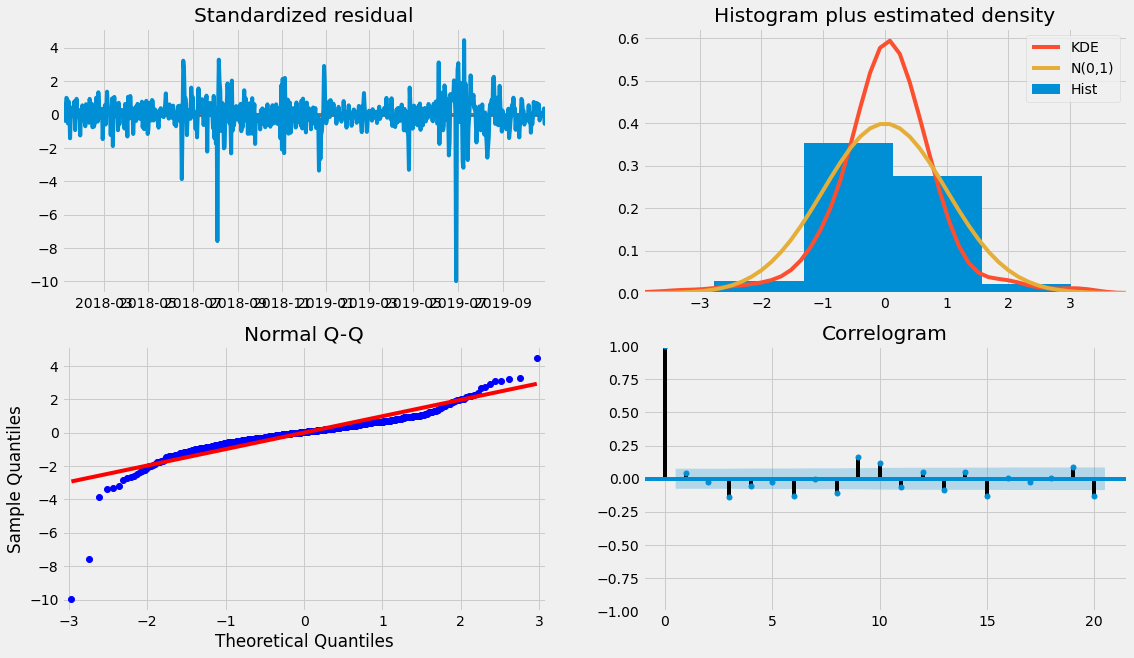

In [ ]:
# Visualizzo i grafico di diagnostic
ar1.plot_diagnostics();

#### Modello standard: Predizione novembre e dicembre 2019
Dato che il modello risulta essere valido verifico se il fitting è buono confrontandolo coi dati reali di novembre e dicembre 2019 tenuti da parte per effettuare questo controllo. 

In [ ]:
# calcolo lo score sul training set
score_train = r2_score(df_train[1:].kWh, ar1.predict(start='2018-01-02', 
                                                     end='2019-10-31',
                                                     typ='levels'))

# calcolo lo score sul test set, quindi predicendo i valori sui mesi finali del 2019
score_test = r2_score(df_test.kWh, ar1.predict(start='2019-11-01', 
                                               end = '2019-12-31', 
                                               typ='levels'))

Il modello risulta essere ottimale sui dati fittati, con uno score $R^2$ molto alto, mentre su nuovi valori risulta essere **pessimo** con uno score addirittura negativo. Questa diversità la si può notare sia dal valore puntuale dello score sia dai due grafici in cui risulta evidente la diversità del fitting tra valori predetti e valori reali.

Score ARIMA (7,1,8) su training set: 0.8413553473026824


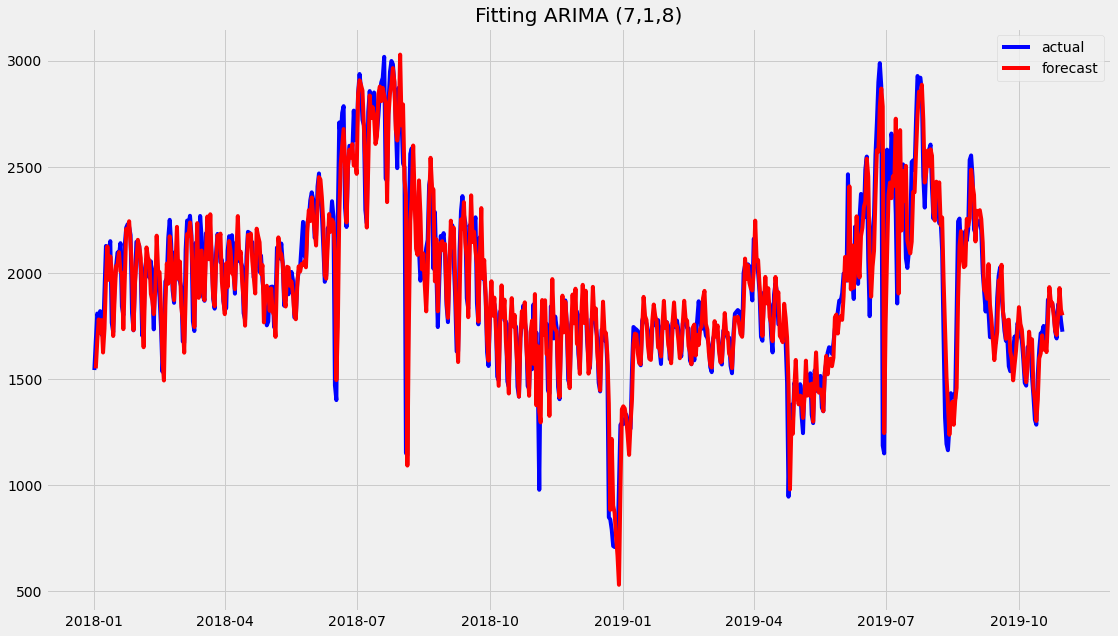

In [ ]:
# Score e grafico sui valori del training set
print("Score ARIMA (7,1,8) su training set:", score_train)

plt.plot(df_train.kWh, color='blue', label="actual")
plt.plot(ar1.fittedvalues[1:], color='red', label="forecast")
plt.legend(loc="upper right")
plt.title("Fitting ARIMA (7,1,8)");

Sebbene il fitting sui valori di training è davvero ottimo il fitting su i valori predetti di fine 2019 è pessimo, infatti il modello non interpola il trend e le stagionalità presenti nella serie e predice un andamento costante lontano dai valori reali.

Score ARIMA (7,1,8) sul test set: -0.7143383161082417


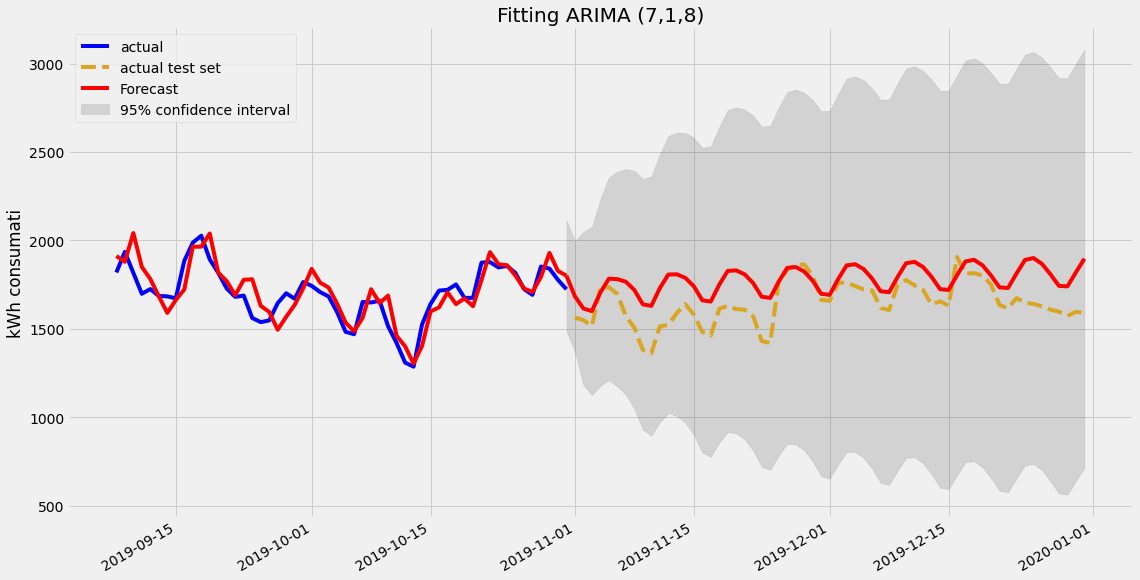

In [ ]:
# Score e grafico sui valori del test set
print("Score ARIMA (7,1,8) sul test set:", score_test)


fig, ax = plt.subplots() 

# show test + training set
plt.plot(df_train.kWh[615:], color='blue', label="actual")
plt.plot(df_test.kWh, '--', color='goldenrod', label="actual test set")

# show fitted values 
plt.plot(ar1.fittedvalues[615:], color='red')

# show forecast + confidence
fcast = ar1.get_prediction(start= '2019-10-31', 
                           end='2019-12-31').summary_frame(alpha=0.05)
fcast['mean'].plot(ax=ax, color='red', label="Forecast")
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], 
                color='k', alpha=0.12, label="95% confidence interval");

# show legend + title
plt.legend(loc="upper left")
plt.title("Fitting ARIMA (7,1,8)");
ax.set(ylabel="kWh consumati");

La predizione non è molto soddisfacente, anche se considerando un intervallo di confidenza all'95% i valori cadono tutti al suo interno. Provo allora a cambiare approccio per la previsione diminuendo la finestra temporale.

#### One-step ahead
Dato che il modello non riesce a prevedere i nuovi valori cerco di migliorare la situazione utilizzando il modello one-step ahead che predice un solo nuovo valore alla volta. Questo modello è limitante in quanto la previsione è molto ristretta, cercherò poi di aumentare la finestra di previsione.

In [ ]:
# indice fin dove fittare il modello, all'inizio fitto fino a 2019-10-31, man mano aggiungo 1gg
end_index = len(df_train)
# iterazione necessarie per arrivare fino al 2019-12-31
max_iters = len(df_U1_19) - len(df_train)

In [ ]:
# salvo tutte le predizioni fatte di volta in volta
prediction_df = pd.DataFrame()

for i in range(0, max_iters):
  ar2 = SARIMAX(df_U1_19.kWh[:end_index], order=(7,1,8)).fit()

  # prevedo a 1 gg con confidenza 95%
  temp = ar2.get_prediction(start = end_index, 
                            end = end_index).summary_frame(alpha=0.05)
  prediction_df = prediction_df.append(temp)
  
  # proseguo con la previsione di 1gg
  end_index += 1

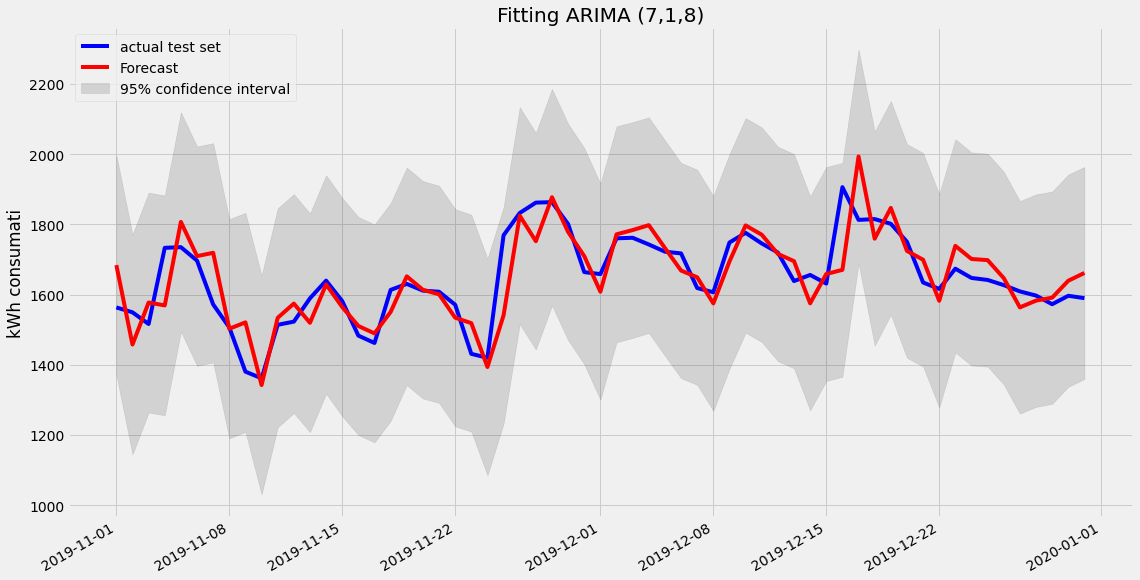

In [ ]:
# visualizzo tutti i risultati ottenuti
fig, ax = plt.subplots() 

# show test + training set
plt.plot(df_test.kWh, color='blue', label="actual test set")

# show forecast + confidence
prediction_df['mean'].plot(ax=ax, color='red', label="Forecast")
ax.fill_between(prediction_df.index, prediction_df['mean_ci_lower'], prediction_df['mean_ci_upper'], 
                color='k', alpha=0.12, label="95% confidence interval");

# show legend + title
plt.legend(loc="upper left")
plt.title("Fitting ARIMA (7,1,8)");
ax.set(ylabel="kWh consumati");

Diminuendo drasticamente la finestra la predizione migliora e diventa molto accurata, anche lo score che prima era fortemente negativo ora diventa molto buono con un valore sopra lo 0.5. L'aspetto negativo di questo approccio è però che l'algoritmo va eseguito ogni giorno per avere la nuova predizione.

In [ ]:
print("R2 previsione a 1gg: ", r2_score(df_test.kWh, prediction_df['mean']))

0.6139616519863256

#### Previsione a 5 e 7 giorni
Come detto il modello precedente, seppur molto buono a prevedere, è limitante in quanto la previsione è solo sul giorno successivo. Provo allora a estendere la finestra e prevedere a 5 giorni e successivamente a 7

In [ ]:
# numero di predizioni in avanti
num_steps_pred = 5
# indice fin dove fittare il modello, all'inizio fitto fino a 2019-10-31, man mano aggiungo 5gg
end_index = len(df_train)
# iterazione necessarie per arrivare fino al 2019-12-31
max_iters = (len(df_U1_19) - len(df_train))/num_steps_pred

In [ ]:
# salvo tutte le predizioni fatte di volta in volta
prediction_df_5 = pd.DataFrame()

for i in range(0, round(max_iters)):
  ar3 = SARIMAX(df_U1_19.kWh[:end_index], order=(7,1,8)).fit()

  # prevedo a 1 gg con confidenza 95%
  end_pred = end_index + num_steps_pred -1
  temp = ar3.get_prediction(start = end_index, end = end_pred).summary_frame(alpha=0.05)
  prediction_df_5 = prediction_df_5.append(temp)
  
  # proseguo con la previsione di 5gg
  end_index += num_steps_pred

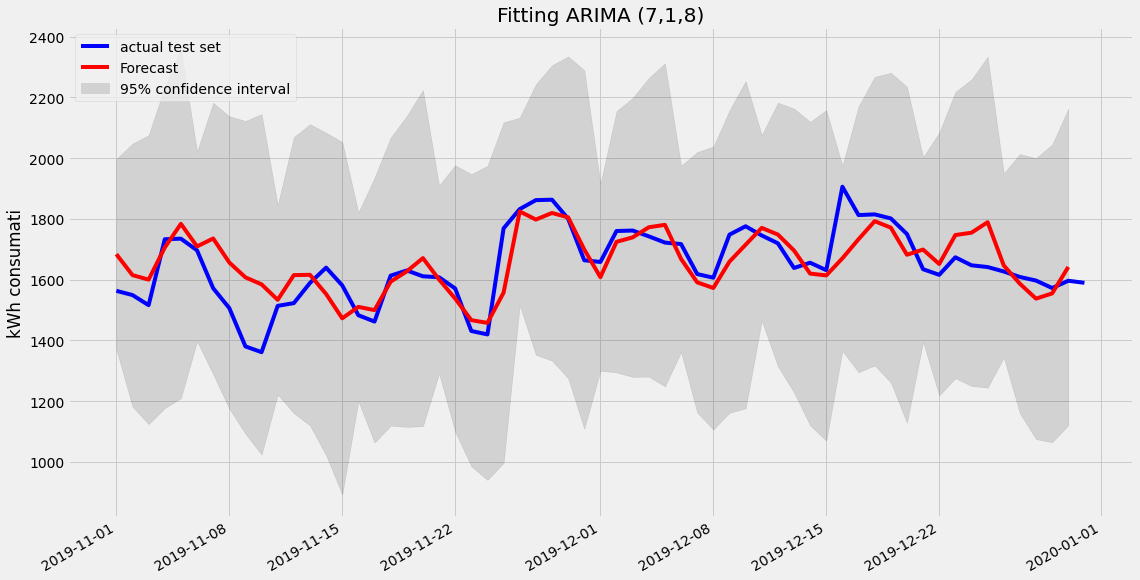

In [ ]:
# visualizzo tutti i risultati ottenuti
fig, ax = plt.subplots() 

# show test + training set
plt.plot(df_test.kWh, color='blue', label="actual test set")

# show forecast + confidence
prediction_df_5['mean'].plot(ax=ax, color='red', label="Forecast")
ax.fill_between(prediction_df_5.index, prediction_df_5['mean_ci_lower'], 
                prediction_df_5['mean_ci_upper'], color='k', alpha=0.12, 
                label="95% confidence interval");

# show legend + title
plt.legend(loc="upper left")
plt.title("ARIMA (7,1,8): predizione a 5 giorni");
ax.set(ylabel="kWh consumati");

In [ ]:
print("R2 previsione a 5gg: ", r2_score(df_test.kWh[:60], prediction_df_5['mean']))

0.5151502677634601

La previsione a 5gg risulta essere leggermente meno accurata rispetto a quella di un solo giorno in avanti però l'$R^2$ rimane elevato. Aumentando la previsione fino a 7gg, si nota un'ulteriore diminuzione del valore dell'$R^2$ fino a 0.35

In [ ]:
# numero di predizioni in avanti
num_steps_pred = 7
# indice fin dove fittare il modello, all'inizio fitto fino a 2019-10-31, man mano aggiungo 5gg
end_index = len(df_train)
# iterazione necessarie per arrivare fino al 2019-12-31
max_iters = (len(df_U1_19) - len(df_train))/num_steps_pred


# salvo tutte le predizioni fatte di volta in volta
prediction_df_7 = pd.DataFrame()

for i in range(0, round(max_iters)):
  ar4 = SARIMAX(df_U1_19.kWh[:end_index], order=(7,1,8)).fit()

  # prevedo a 1 gg con confidenza 95%
  end_pred = end_index + num_steps_pred -1
  temp = ar4.get_prediction(start = end_index, end = end_pred).summary_frame(alpha=0.05)
  prediction_df_7 = prediction_df_7.append(temp)
  
  # proseguo con la previsione di 7gg
  end_index += num_steps_pred

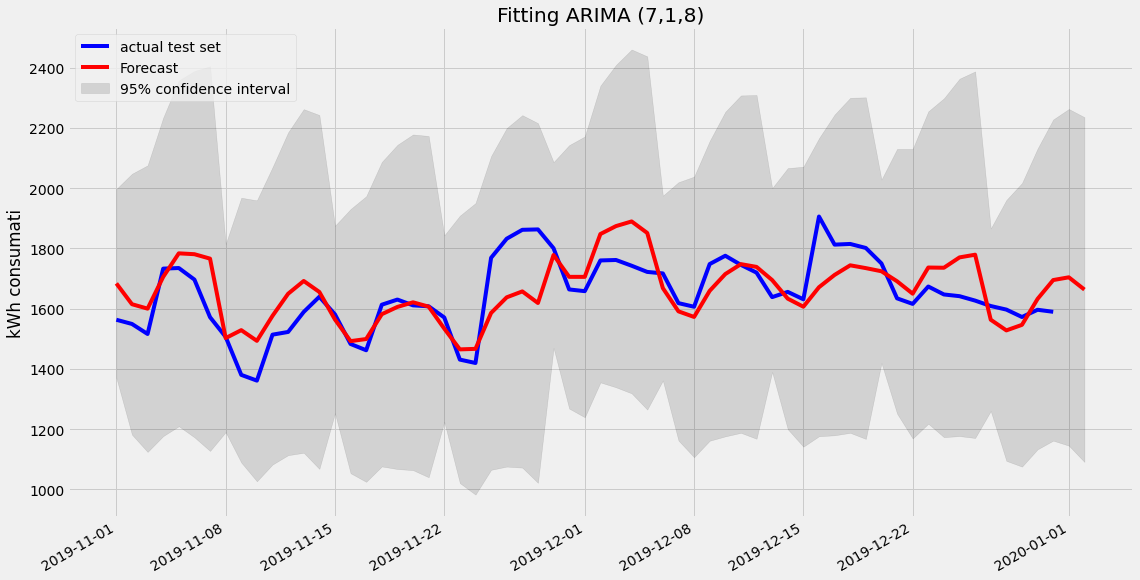

In [ ]:
# visualizzo tutti i risultati ottenuti
fig, ax = plt.subplots() 

# show test + training set
plt.plot(df_test.kWh, color='blue', label="actual test set")

# show forecast + confidence
prediction_df_7['mean'].plot(ax=ax, color='red', label="Forecast")
ax.fill_between(prediction_df_7.index, prediction_df_7['mean_ci_lower'], 
                prediction_df_7['mean_ci_upper'], color='k', alpha=0.12, 
                label="95% confidence interval");

# show legend + title
plt.legend(loc="upper left")
plt.title("ARIMA (7,1,8): predizione a 7 giorni");

ax.set(ylabel="kWh consumati");

In [ ]:
# r2 per i valori fino al 2019
print("R2 previsione a 7gg: ", r2_score(df_test.kWh, prediction_df_7['mean'][:61]))

R2 previsione a 7gg:  0.35694171116292406


#### Modello con stagionalità
Dai modelli fittati finora risulta evidente che il problema è interpolare la stagionalità, il problema è che i dati a disposizione sono troppo pochi per utilizzare modelli appositi, come SARIMAX, che permettano di includere la stagionalità nel fitting iniziale. Provo allora altri approcci come includere la variabile 'Weekday' come covariata e approcci neurali completamente diversi.

#### Previsione a 7 giorni con weekday come covariata
Dato che il modello precedente con previsione a 7gg dava risultati buoni ma non ottimali provo a migliorarli includendo una covariata nel modello. In questo caso la covariata aggiunta è abbastanza basilare e riguarda il giorno della settimana. <br>
Lo stesso modello può essere applicato per le previsioni a 5gg ma in questo caso non si è notato un miglioramento nell'accuracy dei valori predetti anche con la covariata.

In [ ]:
# numero di predizioni in avanti
num_steps_pred = 7
# indice fin dove fittare il modello, all'inizio fitto fino a 2019-10-31, man mano aggiungo 5gg
end_index = len(df_train)
# iterazione necessarie per arrivare fino al 2019-12-31
max_iters = (len(df_U1_19) - len(df_train))/num_steps_pred

# convert list to numpy array
exog_val = df_U1_19['Weekday'].values

In [ ]:
# salvo tutte le predizioni fatte di volta in volta
prediction_df_cov = pd.DataFrame()

for i in range(0, round(max_iters)):
  # fitto il modello passando anche i valori della covariata
  ar5 = SARIMAX(df_U1_19.kWh[:end_index], order=(7,1,8),
                exog=exog_val[:end_index]).fit()

  # prevedo a 7 gg con confidenza 95%
  end_pred = end_index + num_steps_pred -1

  """ 
      inserisco il try perchè i giorni non sono divisibili in modo intero per 7
      in questo modo gli ultimi valori che rimangono fuori e darebbero errore 
      nella predizione vengono saltati.
      L'errore è dovuto alla mancanza dei valori per la covariata, in quanto si 
      fermano al 2019-12-31 mentre la predizione finale 'sfora' anche ai primi
      giorni del 2020
  """
  try:
    temp = ar5.get_prediction(start = end_index, end = end_pred,
                              exog=exog_val[end_index:end_pred+1].reshape(7,1)).summary_frame(alpha=0.05)
    prediction_df_cov = prediction_df_cov.append(temp)
  except:
    pass

  # proseguo con la previsione di 7gg con covariata
  end_index += num_steps_pred

Il modello con l'introduzione della covariata risulta essere leggermente meglio del modello standard, si può notare infatti che la correlazione a diversi lag ora rientra molto di più nella banda di normalità a differenza di prima.

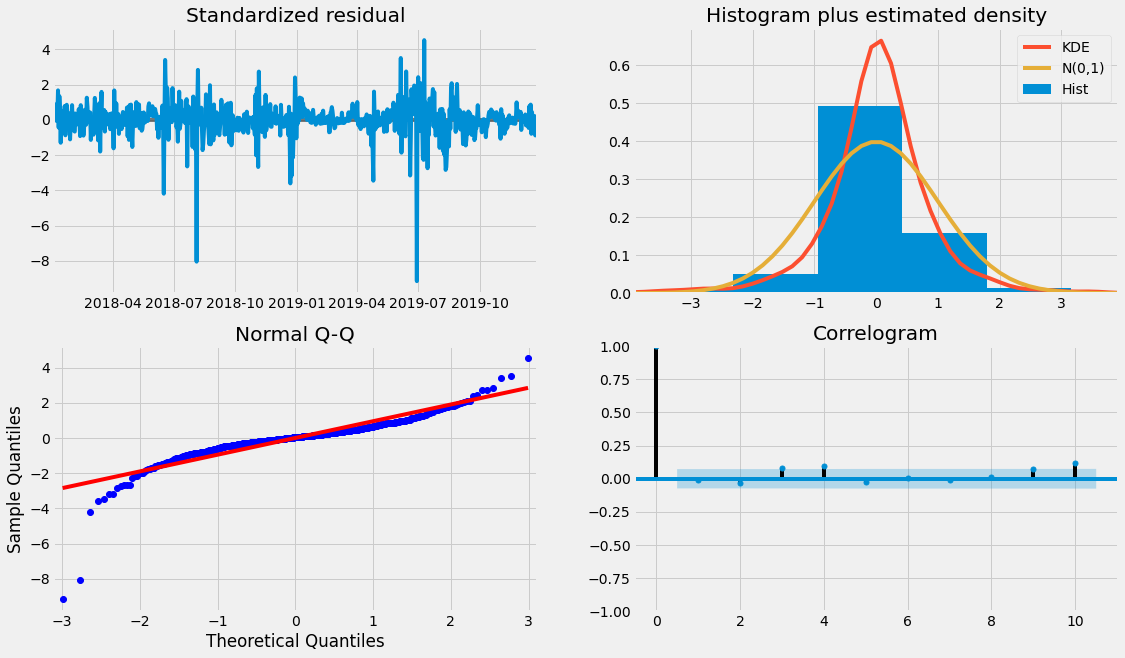

In [ ]:
# diagnostica del modello con covariata
ar5.plot_diagnostics();

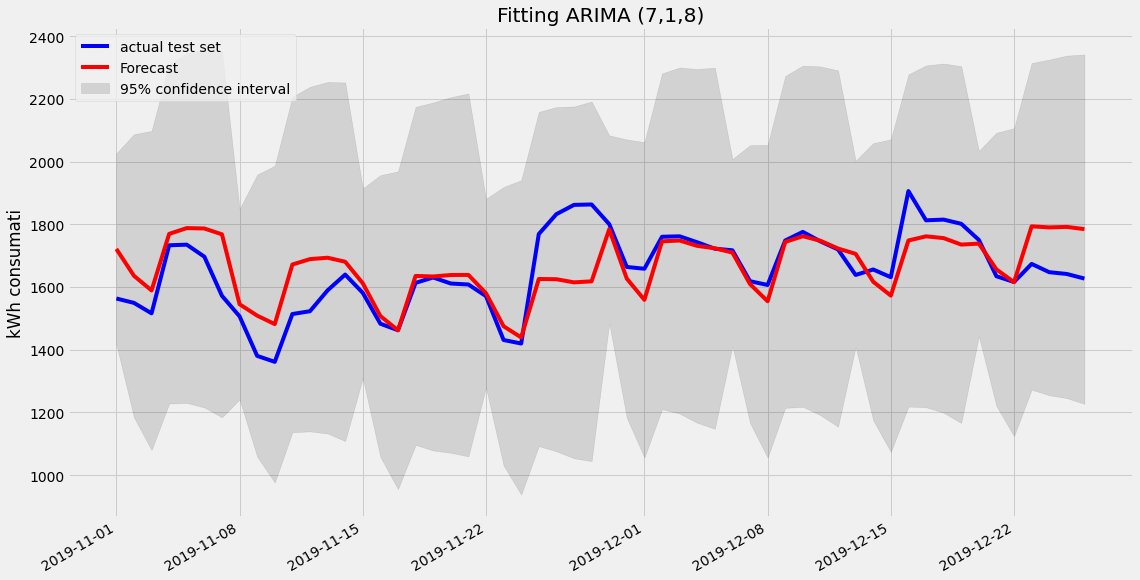

In [ ]:
# visualizzo tutti i risultati ottenuti
fig, ax = plt.subplots() 

# show test + training set
plt.plot(df_test.kWh[:56], color='blue', label="actual test set")

# show forecast + confidence
prediction_df_cov['mean'].plot(ax=ax, color='red', label="Forecast")
ax.fill_between(prediction_df_cov.index, prediction_df_cov['mean_ci_lower'], 
                prediction_df_cov['mean_ci_upper'], color='k', alpha=0.12, 
                label="95% confidence interval");

# show legend + title
plt.legend(loc="upper left")
plt.title("ARIMA (7,1,8): predizione a 7 giorni con covariata weekday");
ax.set(ylabel="kWh consumati");

In [ ]:
# r2 per i valori fino al 2019 con covariata weekday
print("R2 previsione a 5gg con covariata: ", r2_score(df_test.kWh[:56], prediction_df_cov['mean']))

R2 previsione a 5gg con covariata:  0.3920374303678572


Questo nuovo modello con covariata risulta essere leggermente migliore al modello senza covariata.<br>

#### Modelli neurali
Va preso da rebecca :)

### ARIMA (7,1,8). Anni 2018-2020
Dato che dalle analisi iniziali l'anno 2020 faceva registrare un decremento dei valori del consumo molto simile a quello del 2019 provo ad introdurlo nelle analisi considerandolo quindi come un anno normale, nonostante il covid. <br>
Aggiungendo il 2020 i modelli standard hanno lo stesso problema dei precedenti, ovvero non interpolano correttamente la stagionalità e il trend della serie storica. Per questo motivo inizio a fittare direttamente i modelli con previsione a 5 e 7 giorni sia con covariata che senza.

#### Previsione a 5 e 7 giorni

In [ ]:
# numero di predizioni in avanti
num_steps_pred = 5
# indice fin dove fittare il modello, all'inizio fitto fino a 2019-12-31, man mano aggiungo 5gg
end_index = len(df_U1_19)
# iterazione necessarie per arrivare fino al 2020-12-31
max_iters = (len(df_U1) - len(df_U1_19))/num_steps_pred

In [ ]:
# salvo tutte le predizioni fatte di volta in volta
prediction_df2020_5 = pd.DataFrame()

for i in range(0, round(max_iters)):
  ar6 = SARIMAX(df_U1.kWh[:end_index], order=(7,1,8)).fit()

  # prevedo a 1 gg con confidenza 95%
  end_pred = end_index + num_steps_pred -1
  temp = ar6.get_prediction(start = end_index, end = end_pred).summary_frame(alpha=0.05)
  prediction_df2020_5 = prediction_df2020_5.append(temp)
  
  # proseguo con la previsione di 5gg
  end_index += num_steps_pred

LinAlgError: ignored

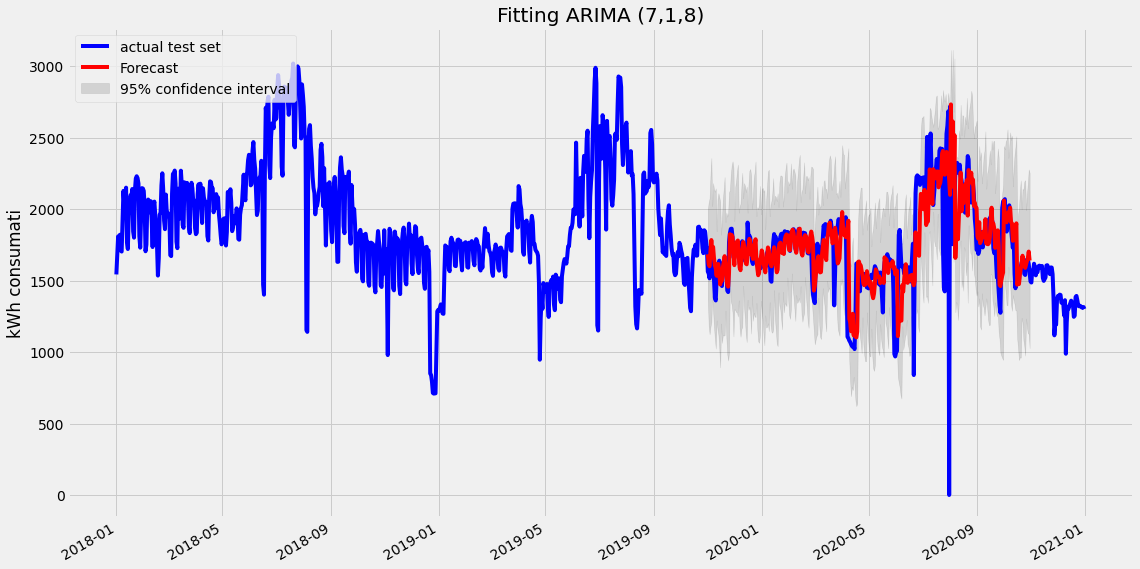

In [ ]:
# visualizzo tutti i risultati ottenuti
fig, ax = plt.subplots() 

# show test + training set
plt.plot(df_U1.kWh, color='blue', label="actual test set")

# show forecast + confidence
prediction_df2020_5['mean'].plot(ax=ax, color='red', label="Forecast")
ax.fill_between(prediction_df2020_5.index, prediction_df2020_5['mean_ci_lower'], 
                prediction_df2020_5['mean_ci_upper'], color='k', alpha=0.12, 
                label="95% confidence interval");

# show legend + title
plt.legend(loc="upper left")
plt.title("Fitting ARIMA (7,1,8)");
ax.set(ylabel="kWh consumati");

In [ ]:
r2_score(df_U1.loc['2020-01-01':'2020-12-31'].kWh, prediction_df2020_5['mean'])

0.38590178656197693

#### Previsione a 7 giorni con weekday come covariata

#### Modello con stagionalità
Avendo aggiunto nuovi dati è ora possibile utilizzare SARIMAX con anche gli ordini per la stagionalità. Purtroppo avendo dati giornalieri Python richiede molto tempo per completare il task e va in 'Out of memory', per questo motivo questa sezione di codice è stata implementata in R per aggirare il problema.

In [ ]:
# activate R magic
%load_ext rpy2.ipython

In [ ]:
%%R
x <- 42
print(x)